# Introduction
This notebook will guide you through creating a classifier that can distinguish between different types of ships.
It is using transfer learning with Google's `EfficientNetB0`.

# Prerequisites

In [1]:
# Installing livelossplot for live metrics viz
# split-folders to create test and validation datasets
!pip install livelossplot
!pip install split-folders

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting, imshow
from matplotlib import gridspec
from livelossplot import PlotLossesKeras
import splitfolders
%matplotlib inline
import tensorflow as tf
import os
import keras
from keras import layers

# Data
### Extracting the archive containing the training data

In [3]:
!tar xzf /kaggle/input/ships2021/ships2021.tgz

In [4]:
ls  "/kaggle/working/train/"

coastguard/     cruiser/    ferry/      smallfish/  vsmallfish/
containership/  cv/         methanier/  submarine/
corvette/       destroyer/  sailing/    tug/


### Split training data into three folders : `train`, `val`, `test`
70 % of the data is used for training  
20 % for validation  
10 % for testing  
This split is only done if the `split` folder does not exist already

In [5]:
if not os.path.exists("./split"):
    splitfolders.ratio("./train/", "./split", seed=1, ratio=(.7, .2, .1))

Copying files: 49517 files [00:06, 7412.80 files/s]


### Create generators for the train, validation and test data
The images are resized to 224, 224 in order to be used by efficient net. We use a batch size of 32.
The test generator must be unshuffled, in order to create the confusion matrix.

In [25]:
data_dir = "/kaggle/working/split/"
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "train",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "val",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir + "test",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)


Found 34655 files belonging to 13 classes.
Found 9899 files belonging to 13 classes.
Found 4963 files belonging to 13 classes.


### Here are the differents classes composing our dataset

In [7]:
class_names = train_ds.class_names
print(class_names)

['coastguard', 'containership', 'corvette', 'cruiser', 'cv', 'destroyer', 'ferry', 'methanier', 'sailing', 'smallfish', 'submarine', 'tug', 'vsmallfish']


### And here are some images from the first batch

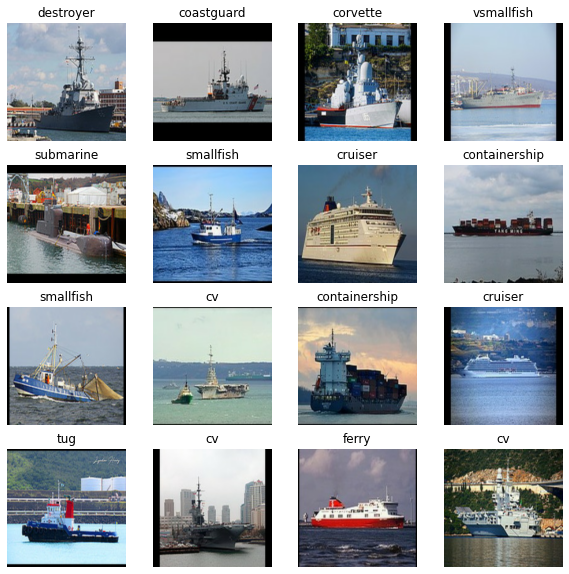

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [9]:
# Here we count the number of file in each class in order to compute the class weights
lbl = []
for dirname, _, filenames in os.walk("/kaggle/working/train/"):
    for filename in filenames:
        lbl.append(dirname.split("/")[-1])

In [10]:
# We set the prefetch to automatic
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# We compute the class weights, ingnoring the future deprecation warnings
from sklearn.utils import class_weight
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    class_weights = class_weight.compute_class_weight('balanced', np.unique(lbl), lbl) 
    class_weights = {i : class_weights[i] for i in range(len(np.unique(lbl)))}

# Model

We first define the data augmentation layers. Those layers are used to modify the data at each epoch, so that the network can recognize rotated, translated or flipped images.

In [12]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomFlip(mode="horizontal"),
        preprocessing.RandomRotation(factor=0.10),
        preprocessing.RandomContrast(factor=0.1),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
    ],
    name="img_augmentation",
)

#### Here the network is defined. we import `EfficientNetB0` without including the top, and add Dense layers at the end
We will first train those layers, with the whole network frozen. Here `EfficientNetB0` is imported using the `imagenet` weights.

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.optimizers import Adam

IMG_SIZE = 224
NUM_CLASSES = 13

inputs = layers.Input(shape=(224,224, 3)) # We create the input layer
inputs = img_augmentation(inputs) # We add the augmentations layers we just created
effnet = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
effnet.trainable = False

model = Sequential()
model.add(effnet)

# Rebuild top
model.add(GlobalMaxPooling2D())
model.add(BatchNormalization())
top_dropout_rate = 0.2
model.add(Dropout(top_dropout_rate))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(13, activation="softmax")) # softmax for our 13 different classes

# Compile
model.compile(
    optimizer=Adam(lr=1e-2), loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]

)

16711680/16705208 [==============================] - 0s 0us/step


### First fit
#### We then fit the model a first time, for 20 epochs

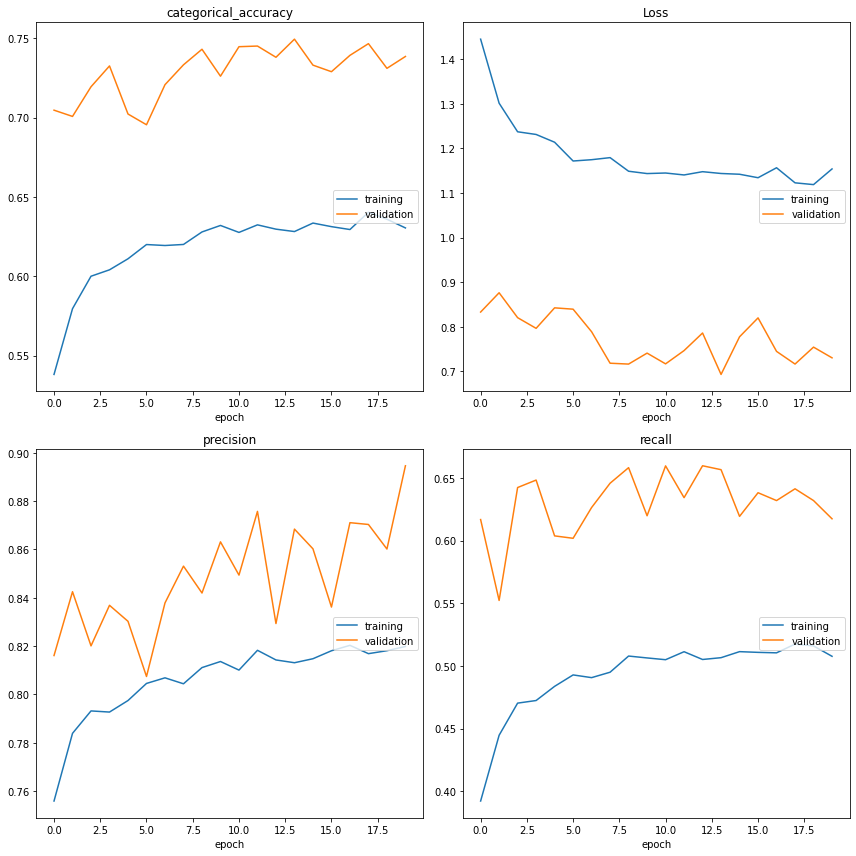

categorical_accuracy
	training         	 (min:    0.538, max:    0.640, cur:    0.631)
	validation       	 (min:    0.696, max:    0.749, cur:    0.739)
Loss
	training         	 (min:    1.119, max:    1.445, cur:    1.154)
	validation       	 (min:    0.693, max:    0.876, cur:    0.731)
precision
	training         	 (min:    0.756, max:    0.820, cur:    0.820)
	validation       	 (min:    0.807, max:    0.895, cur:    0.895)
recall
	training         	 (min:    0.392, max:    0.517, cur:    0.508)
	validation       	 (min:    0.552, max:    0.660, cur:    0.617)


In [14]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    verbose=1,
    callbacks=[PlotLossesKeras()],
    class_weight=class_weights
)

### Unfreeze non BatchNorm layers and fit
The layers that are not BatchNormalization are unfrozen and the whole networked is fitted using the input dataset. It is fitted here for 80 epochs. We also set a lower learning rate.

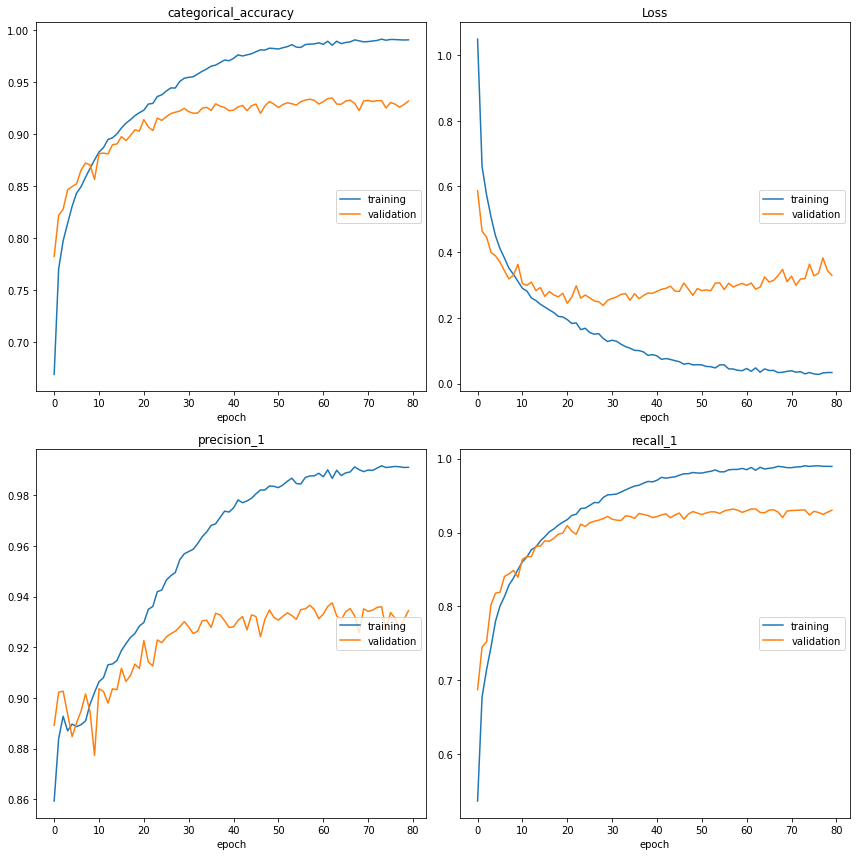

categorical_accuracy
	training         	 (min:    0.669, max:    0.991, cur:    0.990)
	validation       	 (min:    0.782, max:    0.934, cur:    0.932)
Loss
	training         	 (min:    0.028, max:    1.048, cur:    0.033)
	validation       	 (min:    0.238, max:    0.587, cur:    0.330)
precision_1
	training         	 (min:    0.859, max:    0.992, cur:    0.991)
	validation       	 (min:    0.877, max:    0.938, cur:    0.934)
recall_1
	training         	 (min:    0.537, max:    0.990, cur:    0.989)
	validation       	 (min:    0.687, max:    0.932, cur:    0.930)


In [15]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
    )


unfreeze_model(model)

epochs = 80  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1, callbacks=[PlotLossesKeras()], class_weight=class_weights)

# Evaluation
### Evaluation on test dataset
We first use our test data set to evaluate the model, printing the confusion matrix.

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if normalize:
        plt.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap))
    else:
        plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
res = model.evaluate(test_ds)

156/156 [==============================] - 13s 79ms/step - loss: 0.3079 - categorical_accuracy: 0.9369 - recall_1: 0.9361 - precision_1: 0.9420


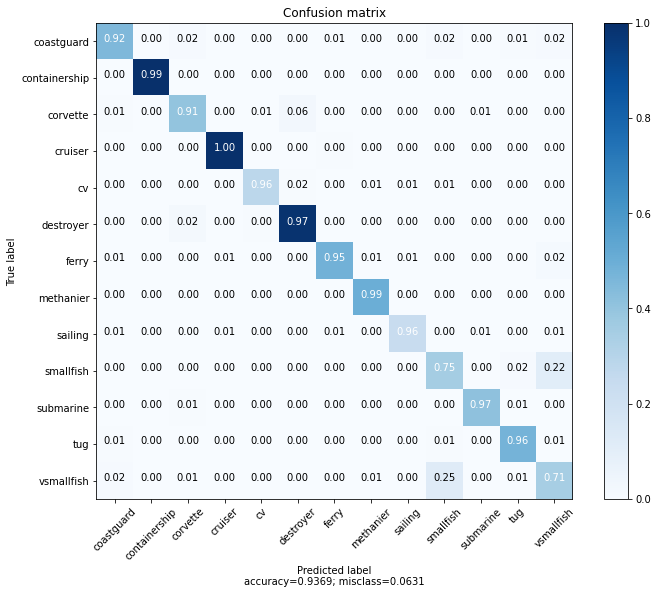

In [28]:
pred_y = model.predict(test_ds).argmax(axis=1) # Prediction on the test dataset, should be the same as evaluation
y = np.concatenate([y for x, y in test_ds], axis=0).argmax(axis=1) # We retrieve the labels from the test dataset
plot_confusion_matrix(confusion_matrix(y, pred_y), class_names, normalize=True) # We print the confusion matrix

We noticde that the only classes that the network really struggles with are `smallfish` and `vsmallfish`. They are very similar.
#### We now print the classification report, which gives valuable information

In [29]:
print(classification_report(y, pred_y, target_names=class_names))

               precision    recall  f1-score   support

   coastguard       0.94      0.92      0.93       331
containership       0.99      0.99      0.99       675
     corvette       0.91      0.91      0.91       295
      cruiser       0.99      1.00      0.99       675
           cv       0.96      0.96      0.96       196
    destroyer       0.96      0.97      0.97       682
        ferry       0.97      0.95      0.96       343
    methanier       0.97      0.99      0.98       337
      sailing       0.97      0.96      0.96       167
    smallfish       0.73      0.75      0.74       319
    submarine       0.98      0.97      0.97       287
          tug       0.96      0.96      0.96       331
   vsmallfish       0.72      0.71      0.72       325

     accuracy                           0.94      4963
    macro avg       0.93      0.93      0.93      4963
 weighted avg       0.94      0.94      0.94      4963



### Evaluation on additional images
#### We will now evaluated the network on 20 images that we found online
Those images are saved in a git repository.

#### Cloning the repo

In [30]:
!git clone https://github.com/elrandar/shipsdataset.git
!rm shipsdataset/README.md
!rm -rf shipsdataset/.git/

Cloning into 'shipsdataset'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 77 (delta 3), reused 75 (delta 1), pack-reused 0
Unpacking objects: 100% (77/77), done.


#### Creating Dataset
Here again we need to disable the shuffling.

In [31]:
test_20_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "shipsdataset/",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 20 files belonging to 13 classes.


#### Show the images

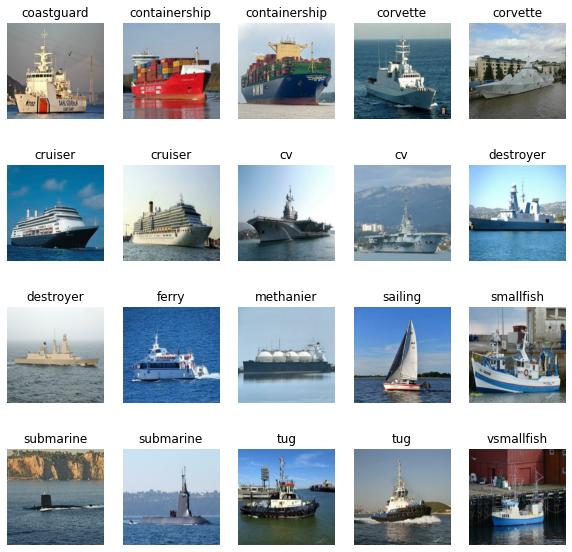

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in test_20_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

#### Evaluate and show confusion matrix

1/1 [==============================] - 0s 271ms/step - loss: 0.3211 - categorical_accuracy: 0.9000 - recall_1: 0.9000 - precision_1: 0.9000


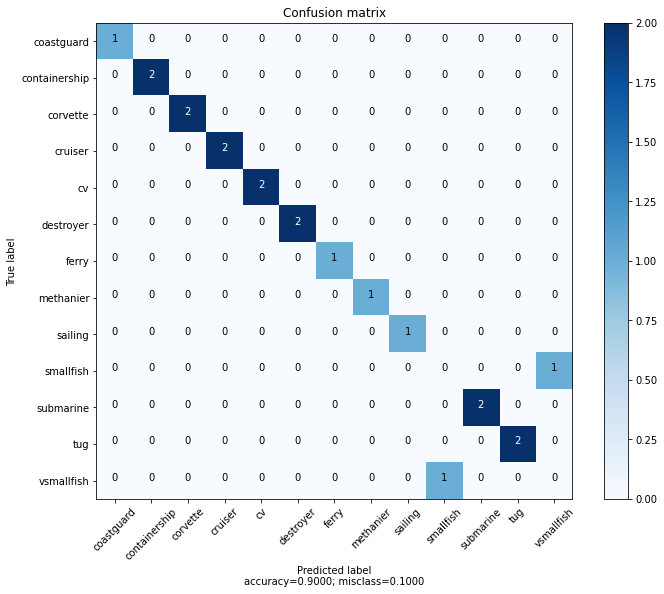

In [33]:
model.evaluate(test_20_ds)
pred_y = model.predict(test_20_ds).argmax(axis=1)
y = np.concatenate([y for x, y in test_20_ds], axis=0).argmax(axis=1)
plot_confusion_matrix(confusion_matrix(y, pred_y), class_names, normalize=False)

#### The network seems to work fine, even on images that were not part of the dataset

### Evaluation on grading dataset

In [17]:
X_test = np.load('/kaggle/working/test_rot.npy', allow_pickle=True)

Images need to be resized to be 224x244

In [18]:
from skimage.transform import resize

X_test_resized = np.zeros((len(X_test), 224, 224, 3))
for n, i in enumerate(X_test):
    X_test_resized[n] = resize(X_test[n], (224, 224), preserve_range=True)

In [19]:
X_test_resized.dtype

dtype('float64')

In [21]:
res = model.predict(X_test_resized).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

In [22]:
!head reco_nav.csv

Id,Category
0,12
1,9
2,2
3,11
4,9
5,1
6,0
7,1
8,12


In [23]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv